# Exploratory data analysis of the UCI Bank Marketing data set

In [1]:
import warnings
warnings.filterwarnings('ignore')

# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')


bank_add_full = pd.read_csv("../data/raw/bank-additional-full.csv", sep=';')

df = bank_add_full
train_df, test_df = train_test_split(df, test_size = 0.20, random_state=123)

alt.data_transformers.disable_max_rows()

numeric_features = ["age", "duration", "campaign", "pdays", "previous", "emp.var.rate", 
                    "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
categorical_features = ["job", "marital", "default", "housing", "loan", "poutcome"]
ordinal_features = ["education"]
education_ordering = ['illiterate', 'basic.4y','basic.6y','basic.9y','high.school',
            'professional.course','university.degree', 'unknown']
target = ["y"]

## Summary of the data set

In [2]:
#df.y.value_counts(), len(df)

In [3]:
#df.info()


The data we are using for this project, [bank-additional-full.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip), was from a marketing campaign of a Portuguese bank. It was sourced from the UCI Learning Repository and can be found on this [website](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

Each row of the data is related to the direct telemarketing campaigns. They were using telemarketing to attempt to get customer to sign up for the bank's term deposit product.  The target in this dataset is yes or no to subscribing to the term deposit product.

There is a total of 41188 examples, 20 features and 0 observations with missing values in the dataset.

| Subscribe | No Subscribe |
| -----------------------: | -----------------------: |
| 4640 | 36548 |
Table 1. Counts of observation for each class.

The data used in this analysis is very simliar to the data used in [Moro et al., 2014].

## Partition the data set into training and test sets

In [4]:
#train_df.y.value_counts(), test_df.y.value_counts()

Before proceeding further, we will split the data such that 80% of observations are in the training and 20% of observations are in the test set. Below we list the counts of observations for each class:

|    Data Partition      | Subscribe | No Subscribe |
| :------------- | -----------------------: | -----------------------: |
| Training     | 3700 | 29250 |
| Test      | 940 | 7298 |
Table 2. Counts of observation for each class for each data partition.

As shown above, there is class imbalance. Our positive for this analysis is for our customers to subscribe to the term deposit. We will try to spot this class so we make sure we capture as many customers as we can with this term deposit product.  We care a bit more about recall than precision because we want to capture as many customers as we can. If we can tune our prediction model to minimize false negatives, the more customers we hope we can get signed up this term deposit product.

We will first attempt to capture the right metrics to find and tune the best model. We note the class imbalance as shown in the table above.  So in addition to our initial tuning, we are prepared to change the training procedures (ex. class weight) and maybe even changing the data (over/under sampling) as we continue our analysis. This will also be dependent on our initial tuning to see if any metrics identify any other problems.




# Exploratory analysis on the training set

To gain an understanding on which features could be helpful in predicting the positive class, we plotted histograms of numeric features (didn't subscibe: blue and subscibed: orange) and percent subscribed bar graphs for each of the categorical features for all observations in the training data set. Although the histograms distributions for all of the numeric features overlap to a certain degree, they do show a difference in their centres and spreads, for example, `age` histogram. For the categorical features, some features are similar in the proportion subscribed, while others seem to be promising in predicting the positive class. The `poutcome` (previous outcome) feature seem to be the best as previous success is highly associated with the positive class. In addition, the features values (`contact`: cellphone, `education`:illitrate, `age_category`:older adults then young adults, and `job`s:retired and student) seem to be associated with the positive class. 


In [5]:
jobs = list(train_df['job'].unique())
jobs_percent_subscribed = {}
for job in jobs:
    subscribed = train_df.query("job == @job & y == 'yes'").shape[0]
    total_surveyed = train_df.query("job == @job").shape[0]
    jobs_percent_subscribed[job] = [total_surveyed, subscribed, round(subscribed/total_surveyed, 2)*100] 
jobs_percent_subscribed_df = pd.DataFrame.from_dict(jobs_percent_subscribed, orient='index')
jobs_percent_subscribed_df = jobs_percent_subscribed_df.reset_index().rename(columns={"index": "job", 0: "total_surveyed", 1 : "subscribed", 2 : "percent_subscribed"})

jobs_plot = alt.Chart(jobs_percent_subscribed_df, title="Jobs").mark_bar().encode(
    x=alt.X('percent_subscribed', scale=alt.Scale(domain=(0, 100))),
    y=alt.Y('job', sort='x')
).properties(width=250)


In [6]:
def discretize(age):
    """Discretize numeric age into one of three categories."""
    if not isinstance(age, (int, float)):
        raise TypeError("Input should be a number!")
    if 17 <= age <= 35:
        return "young adults"
    elif 36 <= age <= 55:
        return "middle-aged"
    elif age > 55:
        return "older adults"
    
train_df_age_category = train_df
train_df_age_category["age_category"] = train_df_age_category["age"].apply(lambda row: discretize(row))

age_categories = list(train_df_age_category['age_category'].unique())
age_percent_subscribed = {}
for age_category in age_categories:
    subscribed = train_df_age_category.query("age_category == @age_category & y == 'yes'").shape[0]
    total_surveyed = train_df_age_category.query("age_category == @age_category").shape[0]
    age_percent_subscribed[age_category] = [total_surveyed, subscribed, round(subscribed/total_surveyed, 2)*100] 
age_percent_subscribed_df = pd.DataFrame.from_dict(age_percent_subscribed, orient='index')
age_percent_subscribed_df = age_percent_subscribed_df.reset_index().rename(columns={"index": "age_category", 0: "total_surveyed", 1 : "subscribed", 2 : "percent_subscribed"})

age_categories_plot = alt.Chart(age_percent_subscribed_df, title="Age Category").mark_bar().encode(
    x=alt.X('percent_subscribed', scale=alt.Scale(domain=(0, 100))),
    y=alt.Y('age_category', sort=["older adults", "middle-aged", "young adults"])
).properties(width=250)

In [7]:
poutcomes = list(train_df['poutcome'].unique())
poutcome_percent_subscribed = {}
for poutcome in poutcomes:
    subscribed = train_df.query("poutcome == @poutcome & y == 'yes'").shape[0]
    total_surveyed = train_df.query("poutcome == @poutcome").shape[0]
    poutcome_percent_subscribed[poutcome] = [total_surveyed, subscribed, round(subscribed/total_surveyed, 2)*100] 
poutcome_percent_subscribed_df = pd.DataFrame.from_dict(poutcome_percent_subscribed, orient='index')
poutcome_percent_subscribed_df = poutcome_percent_subscribed_df.reset_index().rename(columns={"index": "poutcome", 0: "total_surveyed", 1 : "subscribed", 2 : "percent_subscribed"})

poutcomes_plot = alt.Chart(poutcome_percent_subscribed_df, title="Previous outcome").mark_bar().encode(
    x=alt.X('percent_subscribed', scale=alt.Scale(domain=(0, 100))),
    y=alt.Y('poutcome', sort='x')
).properties(width=250)

In [8]:
default_values = list(train_df['default'].unique())
default_percent_subscribed = {}
for default in default_values:
    subscribed = train_df.query("default == @default & y == 'yes'").shape[0]
    total_surveyed = train_df.query("default == @default").shape[0]
    default_percent_subscribed[default] = [total_surveyed, subscribed, round(subscribed/total_surveyed, 2)*100] 
default_percent_subscribed_df = pd.DataFrame.from_dict(default_percent_subscribed, orient='index')
default_percent_subscribed_df = default_percent_subscribed_df.reset_index().rename(columns={"index": "default", 0: "total_surveyed", 1 : "subscribed", 2 : "percent_subscribed"})

default_plot = alt.Chart(default_percent_subscribed_df, title="Default").mark_bar().encode(
    x=alt.X('percent_subscribed', scale=alt.Scale(domain=(0, 100))),
    y=alt.Y('default', sort='x')
).properties(width=250)

In [9]:
housing_values = list(train_df['housing'].unique())
housing_percent_subscribed = {}
for housing in housing_values:
    subscribed = train_df.query("housing == @housing & y == 'yes'").shape[0]
    total_surveyed = train_df.query("housing == @housing").shape[0]
    housing_percent_subscribed[housing] = [total_surveyed, subscribed, round(subscribed/total_surveyed, 2)*100] 
housing_percent_subscribed_df = pd.DataFrame.from_dict(housing_percent_subscribed, orient='index')
housing_percent_subscribed_df = housing_percent_subscribed_df.reset_index().rename(columns={"index": "housing", 0: "total_surveyed", 1 : "subscribed", 2 : "percent_subscribed"})

housing_plot = alt.Chart(housing_percent_subscribed_df, title="Housing").mark_bar().encode(
    x=alt.X('percent_subscribed', scale=alt.Scale(domain=(0, 100))),
    y=alt.Y('housing', sort='x')
).properties(width=250)

In [10]:
loan_values = list(train_df['loan'].unique())
loan_percent_subscribed = {}
for loan in loan_values:
    subscribed = train_df.query("loan == @loan & y == 'yes'").shape[0]
    total_surveyed = train_df.query("loan == @loan").shape[0]
    loan_percent_subscribed[loan] = [total_surveyed, subscribed, round(subscribed/total_surveyed, 2)*100] 
loan_percent_subscribed_df = pd.DataFrame.from_dict(loan_percent_subscribed, orient='index')
loan_percent_subscribed_df = loan_percent_subscribed_df.reset_index().rename(columns={"index": "loan", 0: "total_surveyed", 1 : "subscribed", 2 : "percent_subscribed"})

loan_plot = alt.Chart(loan_percent_subscribed_df, title="Loan").mark_bar().encode(
    x=alt.X('percent_subscribed', scale=alt.Scale(domain=(0, 100))),
    y=alt.Y('loan', sort='x')
).properties(width=250)

In [11]:
marital_values = list(train_df['marital'].unique())
marital_percent_subscribed = {}
for marital in marital_values:
    subscribed = train_df.query("marital == @marital & y == 'yes'").shape[0]
    total_surveyed = train_df.query("marital == @marital").shape[0]
    marital_percent_subscribed[marital] = [total_surveyed, subscribed, round(subscribed/total_surveyed, 2)*100] 
marital_percent_subscribed_df = pd.DataFrame.from_dict(marital_percent_subscribed, orient='index')
marital_percent_subscribed_df = marital_percent_subscribed_df.reset_index().rename(columns={"index": "marital", 0: "total_surveyed", 1 : "subscribed", 2 : "percent_subscribed"})

marital_plot = alt.Chart(marital_percent_subscribed_df, title="Marital Status").mark_bar().encode(
    x=alt.X('percent_subscribed', scale=alt.Scale(domain=(0, 100))),
    y=alt.Y('marital', sort='x')
).properties(width=250)

In [12]:
education_values = list(train_df['education'].unique())
education_percent_subscribed = {}
for education in education_values:
    subscribed = train_df.query("education == @education & y == 'yes'").shape[0]
    total_surveyed = train_df.query("education == @education").shape[0]
    education_percent_subscribed[education] = [total_surveyed, subscribed, round(subscribed/total_surveyed, 2)*100] 
education_percent_subscribed_df = pd.DataFrame.from_dict(education_percent_subscribed, orient='index')
education_percent_subscribed_df = education_percent_subscribed_df.reset_index().rename(columns={"index": "education", 0: "total_surveyed", 1 : "subscribed", 2 : "percent_subscribed"})

education_plot = alt.Chart(education_percent_subscribed_df, title="Education").mark_bar().encode(
    x=alt.X('percent_subscribed', scale=alt.Scale(domain=(0, 100))),
    y=alt.Y('education', sort=education_ordering)
).properties(width=250)

In [13]:
contact_values = list(train_df['contact'].unique())
contact_percent_subscribed = {}
for contact in contact_values:
    subscribed = train_df.query("contact == @contact & y == 'yes'").shape[0]
    total_surveyed = train_df.query("contact == @contact").shape[0]
    contact_percent_subscribed[contact] = [total_surveyed, subscribed, round(subscribed/total_surveyed, 2)*100] 
contact_percent_subscribed_df = pd.DataFrame.from_dict(contact_percent_subscribed, orient='index')
contact_percent_subscribed_df = contact_percent_subscribed_df.reset_index().rename(columns={"index": "contact", 0: "total_surveyed", 1 : "subscribed", 2 : "percent_subscribed"})

contact_plot = alt.Chart(contact_percent_subscribed_df, title="Contact").mark_bar().encode(
    x=alt.X('percent_subscribed', scale=alt.Scale(domain=(0, 100))),
    y=alt.Y('contact')
).properties(width=250)

In [14]:
categorical_plots = (jobs_plot | age_categories_plot | poutcomes_plot) & \
                    (default_plot | housing_plot | loan_plot ) &  \
                    ( marital_plot | education_plot | contact_plot )

In [15]:
df_hist_facet = pd.melt(train_df, id_vars=['y'], value_vars= numeric_features, var_name = 'origin' )

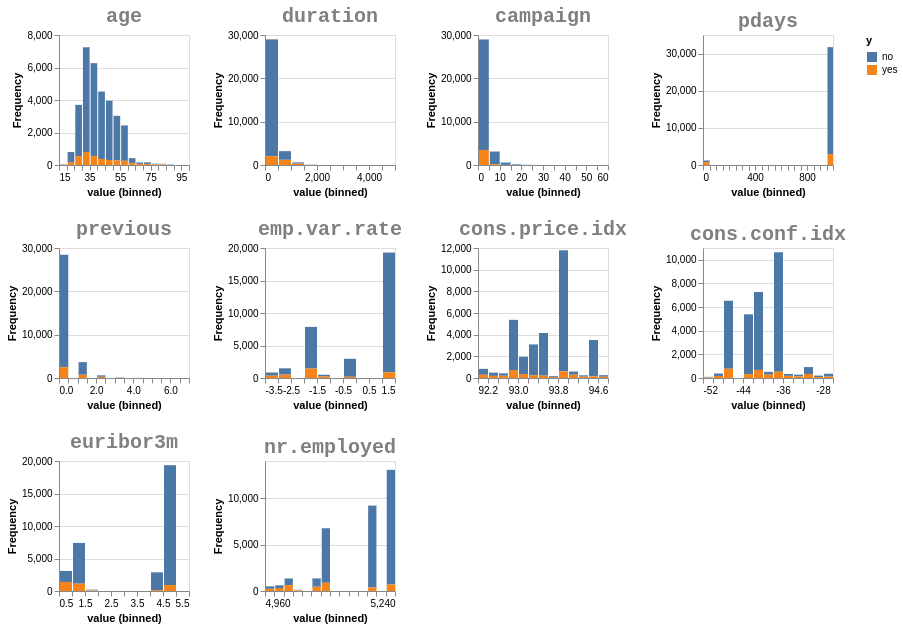

In [16]:

chart= alt.Chart(df_hist_facet).mark_bar().encode(
    x=alt.X('value', bin=alt.Bin(maxbins=20)),
    y=alt.Y('count()', title='Frequency'),
    color='y').properties(
    width=130,
    height=130
)



alt.ConcatChart(
    concat=[
      chart.transform_filter(alt.datum.origin == value).properties(title=value)
      for value in numeric_features
    ],
    columns=4
).configure_title(
    fontSize=20,
    font='Courier',
    anchor='middle',
    color='gray',
    align='left'
).resolve_axis(
    x='independent',
    y='independent'
).resolve_scale(
    x='independent', 
    y='independent'
)

Figure 1. Distribution of numeric features in the training set for subscribers and non-subscribers to the bank's term deposit product.

In [17]:
# for feat in numeric_features:
#     ax = train_df.groupby(target)[feat].plot.hist(bins=20, alpha=0.4, legend=True)
#     plt.xlabel(feat)
#     plt.title("Histogram of " + feat)
#     plt.show()

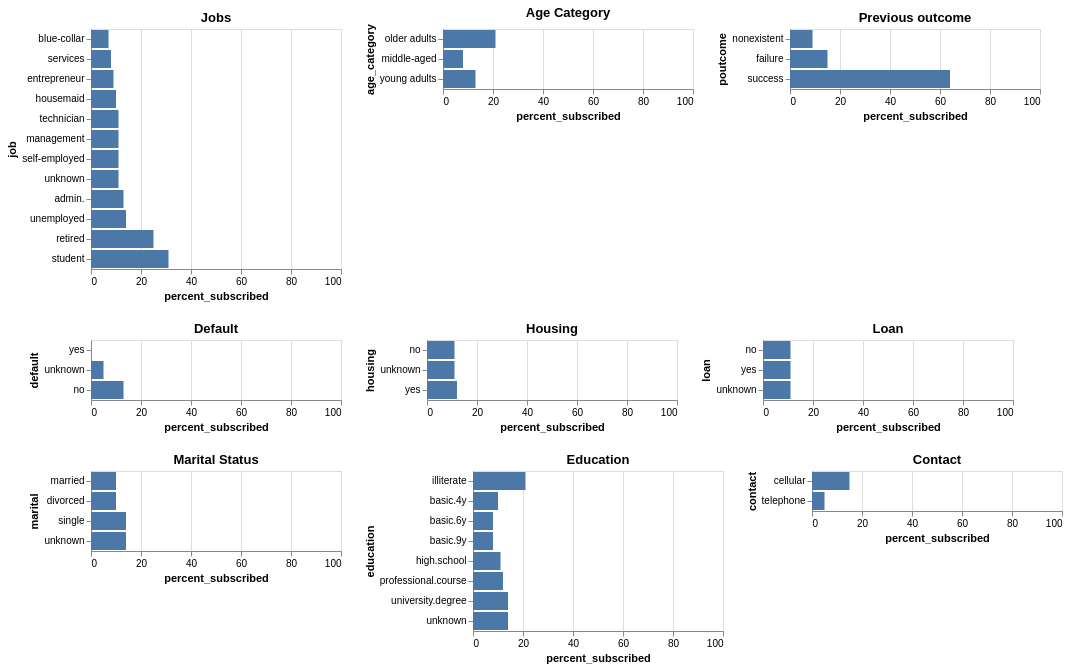

In [18]:
categorical_plots

Figure 2. Distribution of categorical features in the training set for subscribers to the bank's term deposit product.

# References

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014. https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#.


In [19]:
!jupyter nbconvert bank_marketing_data_eda.ipynb --no-input --to html


[NbConvertApp] Converting notebook bank_marketing_data_eda.ipynb to html
[NbConvertApp] Writing 790250 bytes to bank_marketing_data_eda.html
